# Adsorbate Fingerprints Setup

In this tutorial we will try the adsorbate fingerprint generator, which is useful for converting adsorbates on extended surfaces into fingerprints for predicting their chemisorption energies, bond lengths or other properties.

In other machine learning codes, the data usually comes as a matrix where rows represent training examples or unexplored data points, whereas columns represent features or properties of the data points. Therefore the CatLearn fingerprinters expect atoms objects as inputs and they return the data in an array.

In [46]:
# Import packages.
import numpy as np
import ase.io
from ase.data import atomic_numbers
from ase.build import fcc111, add_adsorbate
from ase.constraints import FixAtoms
from ase.visualize import view
from catlearn.fingerprint.setup import FeatureGenerator, default_fingerprinters
from catlearn.fingerprint.periodic_table_data import get_radius, default_catlearn_radius
from catlearn.fingerprint.adsorbate_prep import autogen_info
from catlearn.preprocess.clean_data import clean_infinite, clean_variance
from catlearn.utilities.utilities import target_correlation, holdout_set
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    plot = True
except ImportError:
    print('Pandas and seaborn modules are needed for this tutorial.')

### Generate some adsorbate/surface systems from ASE.

We return the atoms objects in a list, which is the simplest format and easily transferable to CatLearn.

In [47]:
"""Make a list of atoms objects."""
adsorbates = ['H', 'O', 'C', 'N', 'S', 'Cl', 'F']
symbols = ['Ag', 'Au', 'Cu', 'Pt', 'Pd', 'Ir', 'Rh', 'Ni', 'Co']
images = []
for i, s in enumerate(symbols):

    # Get atomic radius.
    rs = get_radius(atomic_numbers[s])
    a = 2 * rs * 2 ** 0.5

    for ads in adsorbates:
        # Create a slab.
        atoms = fcc111(s, (2, 2, 3), a=a)
        atoms.center(vacuum=6, axis=2)
        
        # Constrain the slab.
        c_atoms = [a.index for a in atoms if
                   a.z < atoms.cell[2, 2] / 2. + 0.1]
        atoms.set_constraint(FixAtoms(c_atoms))

        # Specify an adsorbate-surface bond distance.
        h = (default_catlearn_radius(atomic_numbers[ads]) + rs) / 2 ** 0.5

        # Adsorb.
        add_adsorbate(atoms, ads, h, 'bridge')

        # Make list of atoms objects.
        images.append(atoms)
print(len(images), ' atoms objects created.')

63  atoms objects created.


In [48]:
view(images[-1])

Here we have our list of atoms stored in `images`.

### Attach meta data automatically.

The adsorbate fingerprinter generates fingerprints based on connectivity of atoms in the adsorbate/slab system. It therefore uses certain metadata as intermediates between the atoms object and the fingerprint. A connectivity matrix is one of those metadata which can some times be computationally time consuming to generate and therefore needs to be made only once.

A list of raw atoms without the metadata can be feed through `autogen_info` to attach the connectivity matrix and metadata.

In [49]:
images = autogen_info(images)

100%|██████████| 63/63 [00:00<00:00, 189.65it/s]
0it [00:00, ?it/s]/Users/mhangaard/src/CatLearn/catlearn/fingerprint/adsorbate_prep.py:106: UserWarning: 'species' key missing.
  warnings.warn("'species' key missing.")
63it [00:00, 1640.33it/s]


Now let's go ahead and generate our fingerprint matrix.

First we instantiate the FeatureGenerator object and define the fingerprinting functions we want to call. These define what information we retrieve and include in our fingerprints.

In [50]:
# Get the fingerprint generator.
fingerprint_generator = FeatureGenerator(nprocs=1)

# List of feature functions to call. For now let's just grab a default list.
feature_functions = default_fingerprinters(fingerprint_generator, 'adsorbates')

# Feature functions define which fingerprints we generate.
feature_functions

[<bound method AdsorbateFingerprintGenerator.mean_chemisorbed_atoms of <catlearn.fingerprint.setup.FeatureGenerator object at 0x1a212ef080>>,
 <bound method AdsorbateFingerprintGenerator.count_chemisorbed_fragment of <catlearn.fingerprint.setup.FeatureGenerator object at 0x1a212ef080>>,
 <bound method AdsorbateFingerprintGenerator.count_ads_atoms of <catlearn.fingerprint.setup.FeatureGenerator object at 0x1a212ef080>>,
 <bound method AdsorbateFingerprintGenerator.count_ads_bonds of <catlearn.fingerprint.setup.FeatureGenerator object at 0x1a212ef080>>,
 <bound method AdsorbateFingerprintGenerator.mean_site of <catlearn.fingerprint.setup.FeatureGenerator object at 0x1a212ef080>>,
 <bound method AdsorbateFingerprintGenerator.sum_site of <catlearn.fingerprint.setup.FeatureGenerator object at 0x1a212ef080>>,
 <bound method AdsorbateFingerprintGenerator.mean_surf_ligands of <catlearn.fingerprint.setup.FeatureGenerator object at 0x1a212ef080>>,
 <bound method AdsorbateFingerprintGenerator.ter

Return the fingerprint matrix from atoms objects and feature_functions

In [51]:
# Run the fingerprinter 
data_matrix = fingerprint_generator.return_vec(images, feature_functions)

# Get a list of names of the features.
feature_names = fingerprint_generator.return_names(feature_functions)

print(np.shape(data), ' data matrix created.')

  0%|          | 0/63 [00:00<?, ?it/s]/Users/mhangaard/src/CatLearn/catlearn/fingerprint/adsorbate_fingerprint.py:308: RuntimeWarning: Mean of empty slice
  result = list(np.nanmean(dat, axis=0))
/Users/mhangaard/src/CatLearn/catlearn/fingerprint/adsorbate_fingerprint.py:455: RuntimeWarning: Mean of empty slice
  result = list(np.nanmean(dat, axis=0))
/Users/mhangaard/src/CatLearn/catlearn/fingerprint/adsorbate_fingerprint.py:143: RuntimeWarning: Mean of empty slice
  result = list(np.nanmean(dat, axis=0))
/Users/mhangaard/src/CatLearn/catlearn/fingerprint/adsorbate_fingerprint.py:203: RuntimeWarning: Mean of empty slice
  result = list(np.nanmean(dat, axis=0))
/Users/mhangaard/src/CatLearn/catlearn/fingerprint/adsorbate_fingerprint.py:255: RuntimeWarning: Mean of empty slice
  result = list(np.nanmean(dat, axis=0))
100%|██████████| 63/63 [00:00<00:00, 137.45it/s]

(63, 229)  data matrix created.


We are done. The data matrix is now stored in the variable `data_matrix`.

### Let's analyse the output.

First lets see what features were returned by the `feature_functions`:

In [52]:
for l in range(len(feature_names)):
    print(l, feature_names[l])

0 atomic_number_ads1
1 atomic_volume_ads1
2 boiling_point_ads1
3 density_ads1
4 dipole_polarizability_ads1
5 electron_affinity_ads1
6 group_id_ads1
7 lattice_constant_ads1
8 melting_point_ads1
9 period_ads1
10 vdw_radius_ads1
11 covalent_radius_cordero_ads1
12 en_allen_ads1
13 atomic_weight_ads1
14 atomic_radius_ads1
15 heat_of_formation_ads1
16 oxi_min_ads1
17 oxi_med_ads1
18 oxi_max_ads1
19 block_ads1
20 ne_outer_ads1
21 ne_s_ads1
22 ne_p_ads1
23 ne_d_ads1
24 ne_f_ads1
25 ionenergy_ads1
26 ground_state_magmom_ads1
27 nn_num_C
28 nn_num_H
29 nn_num_M
30 total_num_H
31 total_num_C
32 total_num_O
33 total_num_N
34 total_num_S
35 nC-C
36 ndouble
37 nC-H
38 nO-H
39 atomic_number_site_av
40 atomic_volume_site_av
41 boiling_point_site_av
42 density_site_av
43 dipole_polarizability_site_av
44 electron_affinity_site_av
45 group_id_site_av
46 lattice_constant_site_av
47 melting_point_site_av
48 period_site_av
49 vdw_radius_site_av
50 covalent_radius_cordero_site_av
51 en_allen_site_av
52 atomi

Lets check one of the features

Text(0.5,0,'oxi_max_ads1')

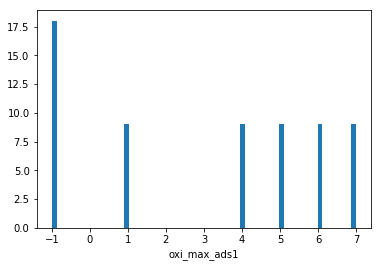

In [53]:
descriptor_index = 18
plt.hist(data_matrix[:, descriptor_index], bins=min([65, len(data)]))
plt.xlabel(feature_names[descriptor_index])

Lets try and compare some of the features about atomic radii using violinplots.

Plotting:
10 vdw_radius_ads1
11 covalent_radius_cordero_ads1
14 atomic_radius_ads1


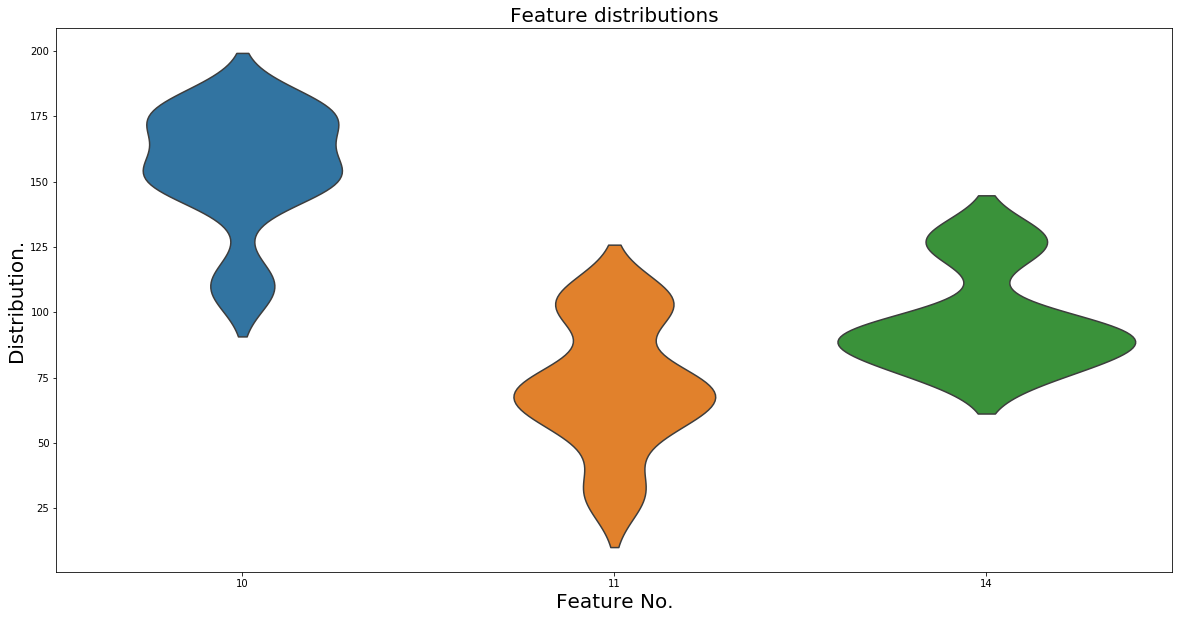

In [54]:
# Select some features to plot.
selection = [10, 11, 14]

# Plot selected of the feature distributions.
plot_data = {}
traint = np.transpose(data_matrix[:, selection])
for i, j in zip(traint, selection):
    plot_data[j] = i
df = pd.DataFrame(plot_data)
fig = plt.figure(figsize=(20, 10))
ax = sns.violinplot(data=df, inner=None)
plt.title('Feature distributions', fontsize=20)
plt.xlabel('Feature No.', fontsize=20)
plt.ylabel('Distribution.', fontsize=20)

string = 'Plotting:'
for s in selection:
    string += '\n' + str(s) + ' ' + feature_names[s]
print(string)

### Clean data

In [55]:
finite_data = clean_infinite(data_matrix, labels=feature_names)
informative_data = clean_variance(finite_data['train'], labels=finite_data['labels'])
training_data = informative_data['train']
clean_features = informative_data['labels']

### Correlations

Text(0,0.5,'Correlation')

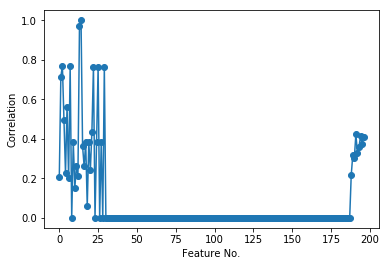

In [56]:
target_feature = 14
target_corr = target_correlation(training_data, training_data[:, target_feature], correlation=['pearson'])
plt.plot(list(range(np.shape(target_corr)[1])), np.abs(target_corr)[0, :], '-o')
plt.xlabel("Feature No.")
plt.ylabel("Correlation")

In [57]:
corr_ordering = np.argsort(np.abs(target_corr)[0, :])[::-1]
np.abs(target_corr)[0, corr_ordering]
print('Highest correlation with', clean_features[target_feature], ':\n')
for i in range(10):
    print(corr_ordering[i], clean_features[corr_ordering][i], np.abs(target_corr)[0, corr_ordering][i])

Highest correlation with oxi_min_ads1 :

14 oxi_min_ads1 1.0
13 heat_of_formation_ads1 0.970289912122
2 boiling_point_ads1 0.768565900511
7 melting_point_ads1 0.76799109318
29 ndouble 0.763762615826
25 total_num_C 0.763762615826
22 ground_state_magmom_ads1 0.763762615826
1 atomic_volume_ads1 0.715268736076
5 electron_affinity_ads1 0.563579828685
3 density_ads1 0.494468495704


In [58]:
view(images[0])

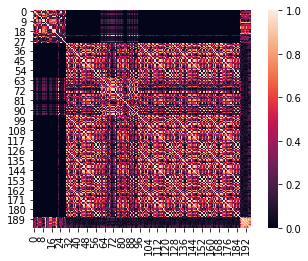

In [59]:
d = pd.DataFrame(training_data)
corr = d.corr(method='pearson')
sns.heatmap(corr.abs(), square=True)

In [60]:
np.abs(target_corr)[0, :][31:36]

array([  0.00000000e+00,   2.63750742e-17,   0.00000000e+00,
         0.00000000e+00,   1.31875371e-17])

In [61]:
clean_features[31:36]

array(['atomic_volume_site_av', 'boiling_point_site_av', 'density_site_av',
       'dipole_polarizability_site_av', 'electron_affinity_site_av'],
      dtype='<U36')

### Analysis of meta data.

Attached to the atoms objects, the fingerprinter needs information about the atoms belonging to the adsorbate. 
This was generate automatically by `autogen_info`, but we can take a closer look at how this meta data is formatted:

In [62]:
# Look at meta data for the first atoms object.
images[0].subsets

{'ads_atoms': [12],
 'bulk_atoms': [0, 1, 2, 3, 4, 5, 6, 7],
 'chemisorbed_atoms': [12],
 'ligand_atoms': [4, 6, 7, 9, 10, 11, 5, 6, 7, 8, 10, 11],
 'site_atoms': [8, 9],
 'slab_atoms': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'subsurf_atoms': [4, 5, 6, 7],
 'termination_atoms': [8, 9, 10, 11]}

E.g. Atomic indices of atoms belonging to the adsorbate are put in `atoms.subsets['ads_atoms']`
There is only one index in that subset, which shows that this system had a monoatomic adsorbate.

In [63]:
# Let's see which one it was.
print('adsorbate:', images[0].get_chemical_symbols()[12])

# What was the site?
print('adsorbate:', np.array(images[0].get_chemical_symbols())[images[0].subsets['site_atoms']])

adsorbate: H
adsorbate: ['Ag' 'Ag']


It was a H* sitting on a Ag-Ag bridge site.

As a user, you can always choose to attach this information and avoid relying on `autogen_info`, if you prefer. There could be various reasons, why the accuracy of `autogen_info` is not always optimal.

`autogen_info` will respect any subsets already present.

Furthermore `autogen_info` builds the subsets using information from a connectivity matrix that is stored in `atoms.connectivity`. If the atoms object already has `atoms.connectivity`, that will be kept and used, otherwise a new one will be created using default cutoffs for neighbor distances.

In [64]:
# Lets look at a connectivity matrix.
images[0].connectivity

array([[0, 2, 2, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [2, 0, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [2, 2, 0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0],
       [2, 2, 2, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 2, 2, 2, 1, 0, 1, 1, 0],
       [1, 1, 1, 0, 2, 0, 2, 2, 0, 1, 1, 1, 0],
       [0, 1, 1, 1, 2, 2, 0, 2, 1, 1, 1, 0, 0],
       [1, 0, 1, 1, 2, 2, 2, 0, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 1, 1, 0, 2, 2, 2, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 2, 2, 1],
       [0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 0, 2, 0],
       [0, 0, 0, 0, 1, 1, 0, 1, 2, 2, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]])

Note that there are some 2's in there. Those are a result of the small unit cell size, where atoms can connect to neighbors in several neighboring unit cells.